# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

/Users/leilasapple/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/Users/leilasapple/.matplotlib/matplotlibrc", line #621
  (fname, cnt))


# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


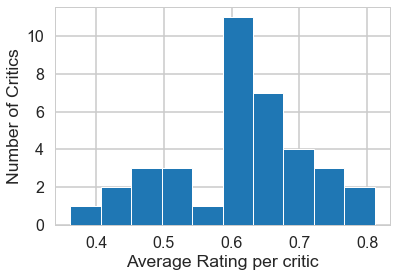

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

In [5]:
counts.head()

critic
A.D. Murphy     13
A.H. Weiler     17
A.O. Scott      19
Aaron Hillis     2
Abel Green       5
Name: critic, dtype: int64

0.6123994405433357 0.6158940397350994 0.8114035087719298 Joe Baltake 0.3620689655172414 Liam Lacey
[  1.   2.   3.   3.   1.  11.   7.   4.   3.   2.] [ 0.36206897  0.40700242  0.45193587  0.49686933  0.54180278  0.58673624
  0.63166969  0.67660315  0.7215366   0.76647005  0.81140351] <a list of 10 Patch objects>
a: 
 : critic
Bosley Crowther       0.695035
Dave Kehr             0.591716
Derek Adams           0.615894
Desson Thomson        0.588235
Edward Guthmann       0.638655
Emanuel Levy          0.629630
Geoff Andrew          0.707736
Hal Hinson            0.530055
James Berardinelli    0.603234
Janet Maslin          0.708738
Jay Carr              0.603604
Jeff Millar           0.554878
Joe Baltake           0.811404
John Hartl            0.655172
Jonathan Rosenbaum    0.599515
Kenneth Turan         0.602151
Kevin Thomas          0.806897
Liam Lacey            0.362069
Lisa Schwarzbaum      0.655172
Michael Wilmington    0.660494
Mick LaSalle          0.538462
Mike Clark          

/Users/leilasapple/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/leilasapple/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


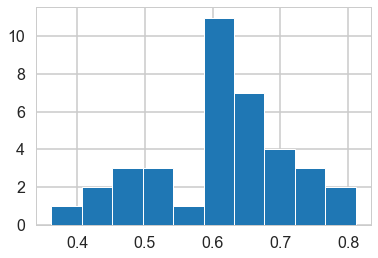

In [6]:
a=means[counts > 100]
print(a.mean(),a.median(),max(a ),np.argmax(a),min(a ),np.argmin(a))
coun, bins, bars = plt.hist(a,bins=10, edgecolor='w', lw=1)
print(coun, bins, bars)
print('a: \n :',a)

<font color='green'> The historam shows average freshness for critics who have more than 100 reviews. The average of the freshness is 0.61 and the median is 0.62. Based on the data, Joe Baltake has maximum freshness of 0.81 and Liam Lacey has minimum freshness of 0.36. The distribution does not present a normal distribution and the is a sudden decrease at freshness between 0.55 to 0.6. The general shape of the histogram suggest that the data may be baised by reviewers who  select which movies they would like to watch and their watchlist is not random. 

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [8]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

In [9]:
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [10]:
critics.shape

(15561, 8)

In [11]:
print('\33[1;30;32mFor X:\nType:',type(X))
print('indices:',X.indices,'\ndate:',X.data,
      '\nuniqe values:',np.unique(X.data),'\nNon zeros:',X.nnz,'\nshape',X.shape
      ,'\nN dimension:',X.ndim,'\nX Sorted?:',X.has_sorted_indices,'\nSum over row:',X.sum(1),
      '\nSum over column:',X.sum(0))
print('\nFor X[0]:\n',X[0],'\nindices:',X[0].indices,'\ndate:',X[0].data,
      '\nuniqe values:',np.unique(X[0].data),'\nNon zeros:',X[0].nnz,'\nshape',X[0].shape
      ,'\nN dimension:',X[0].ndim,'\nX Sorted?:',X[0].has_sorted_indices)
print('\nX[:,0]:',X[:,0].data)

For X:
Type: <class 'scipy.sparse.csc.csc_matrix'>
indices: [ 1028  3215  4740 ..., 10457  4473  8518] 
date: [1 1 1 ..., 1 1 1] 
uniqe values: [ 1  2  3  4  5  6  7  8 10] 
Non zeros: 272265 
shape (15561, 22417) 
N dimension: 2 
X Sorted?: True 
Sum over row: [[24]
 [ 5]
 [12]
 ..., 
 [35]
 [25]
 [21]] 
Sum over column: [[ 8  1 10 ...,  3  1  1]]

For X[0]:
   (0, 891)	2
  (0, 1767)	1
  (0, 2784)	1
  (0, 3248)	1
  (0, 4003)	1
  (0, 4386)	1
  (0, 5251)	1
  (0, 6494)	1
  (0, 6856)	1
  (0, 9950)	1
  (0, 10176)	1
  (0, 10555)	1
  (0, 10566)	1
  (0, 13657)	1
  (0, 14940)	1
  (0, 17231)	1
  (0, 17943)	1
  (0, 18252)	1
  (0, 18757)	1
  (0, 18904)	1
  (0, 19914)	1
  (0, 21732)	1
  (0, 22330)	1 
indices: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
date: [2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 
uniqe values: [1 2] 
Non zeros: 23 
shape (1, 22417) 
N dimension: 2 
X Sorted?: 1

X[:,0]: [1 1 1 1 2 1 1]


## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [12]:
#your turn
# split the data set into a training and test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
print('\33[1;30;32mtraining set size:\t',np.shape(X_train),'\ntest set size:\t\t',np.shape(X_test))
print('training set example:\n',X_train[0])

training set size:	 (11670, 22417) 
test set size:		 (3891, 22417)
training set example:
   (0, 21964)	1
  (0, 21853)	1
  (0, 21031)	1
  (0, 20187)	2
  (0, 19932)	1
  (0, 19929)	1
  (0, 19917)	1
  (0, 19907)	1
  (0, 19570)	1
  (0, 18347)	1
  (0, 17851)	1
  (0, 15850)	1
  (0, 14064)	1
  (0, 13584)	1
  (0, 13535)	1
  (0, 9950)	1
  (0, 9365)	2
  (0, 9106)	1
  (0, 7232)	1
  (0, 6942)	1
  (0, 6754)	1
  (0, 5742)	1
  (0, 5726)	1
  (0, 4386)	1
  (0, 4243)	1
  (0, 2931)	1
  (0, 2584)	1
  (0, 1984)	1
  (0, 1868)	1
  (0, 1485)	1
  (0, 1233)	1
  (0, 891)	2
  (0, 400)	2


/Users/leilasapple/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
#checking value counts of the data
X_values,X_counts=np.unique(X_train.toarray(), return_counts=True)
print('\33[1;30;32mFor X traing set:\n')
#print(X_train[X_train.toarray()==8])
for i,v in enumerate(X_values): print(v,X_counts[i])
print('Number of 1 to 0 ratio in y taring set:', len(y_train[y_train==1])/len(y_train[y_train==0]))

X_values,X_counts=np.unique(X_test.toarray(), return_counts=True)
print('\n\33[1;30;32mFor X test set:\n')
for i,v in enumerate(X_values): print(v,X_counts[i])
print('Number of 1 to 0 ratio in y test set:', len(y_test[y_test==1])/len(y_test[y_test==0]))

del X_values,X_counts

For X traing set:

0 261401985
1 190595
2 11094
3 2056
4 491
5 120
6 38
7 6
8 3
10 2
Number of 1 to 0 ratio in y taring set: 1.5603334795963142

For X test set:

0 87156687
1 63270
2 3719
3 681
4 137
5 38
6 12
7 1
8 2
Number of 1 to 0 ratio in y test set: 1.5581854043392505


<font color='green'>Although the y sets in training set and test set have same ratio of 1 to zero, in the X tarining and test sets the vaiation of the number of values are huge. For example, there are 261401985  of zeros in X tarining set but there are only two 10s. 

In [14]:
#Use scikit-learn's MultinomialNB() classifier with default parameters
from sklearn.naive_bayes import MultinomialNB
MlNB=MultinomialNB()

In [15]:
#train the classifier over the training set and test on the test set
MlNB.fit(X_train,y_train)
y_classified_train=MlNB.predict(X_train)
print('\33[1;30;32mPredicted results on taining set:',y_classified_train)
print('Mean accuracy for traing set:',MlNB.score(X_train, y_train))

y_classified_test=MlNB.predict(X_test)
print('\nPredicted results on test set:',y_classified_test)
print('Mean accuracy for test set:',MlNB.score(X_test,y_test))


Predicted results on taining set: [0 1 0 ..., 1 0 1]
Mean accuracy for traing set: 0.921251071123

Predicted results on test set: [0 1 1 ..., 1 0 0]
Mean accuracy for test set: 0.770753019789


##### <font color='green'>What do you notice? Is this a good classifier? If not, why not?
<font color='green'>The accuancy for training set is about 0.15 higher than test set. It can be due to overfitting to the data or because the data sets were biased. Other reason can be due to poor choice of hyperparameters. 

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [16]:
from collections import Counter
#Construct the cumulative distribution of document frequencies (df)
cd_df=Counter(X.indices) #to count the number each elemnets occured as a sorted dictionary from https://docs.python.org/3.1/library/collections.html#collections.Counter
print('\33[1;30;32m',type(cd_df))
print(sum(cd_df.values()))

 <class 'collections.Counter'>
272265


In [17]:
cd_df=cd_df.values()

/Users/leilasapple/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/leilasapple/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 999 but corresponding boolean dimension is 1000
  """
/Users/leilasapple/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 999 but corresponding boolean dimension is 1000
  


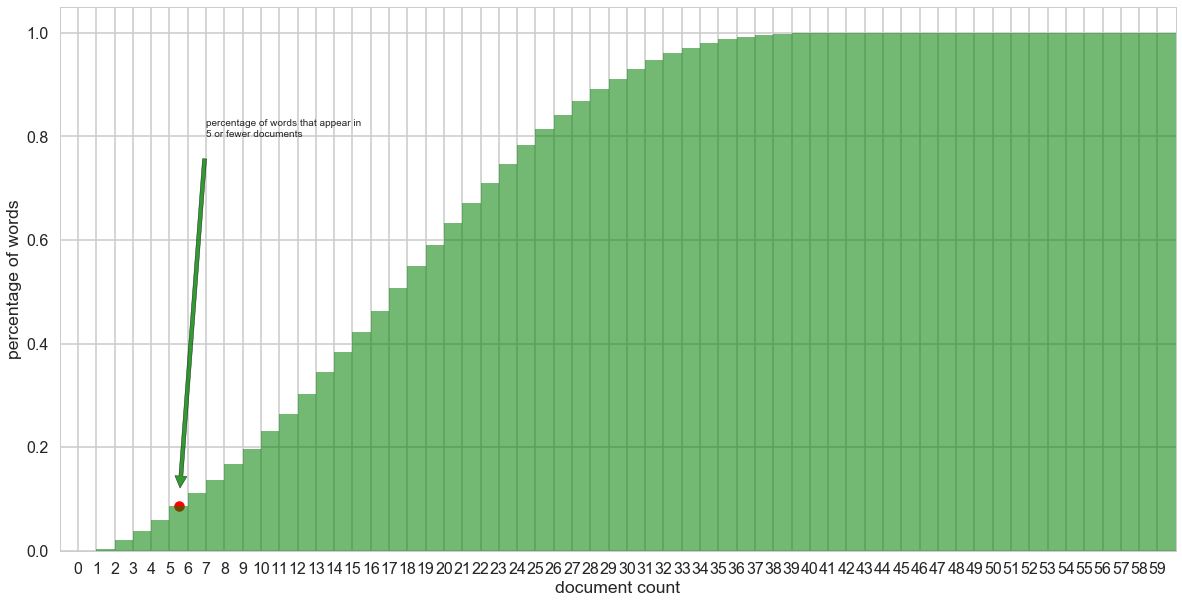

In [18]:
fig,ax=plt.subplots(figsize=(20,10))
cd_bin=range(1000)
cdf, bins, patches=plt.hist(cd_df,bins=cd_bin,normed = 1,color='g',alpha=0.55,cumulative=True)
#plot a point representing the percentage or number of words that appear in 5 or fewer documents
plt.scatter(5.5,cdf[bins == 5], s=100, c='r')
ax.annotate('percentage of words that appear in \n5 or fewer documents ', xy=(5.5, cdf[bins == 5]), xytext=(7, 0.8),
            arrowprops=dict(facecolor='Green', shrink=0.05,alpha=0.8))
plt.xlim(-1,60) 
plt.xticks(range(0,60,1))
plt.xlabel('document count')
plt.ylabel ('percentage of words')
plt.show()

<font color='green'>After 35 documents the CDF plot is almost plateau. Therfore, min_df=35

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [19]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [20]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

In [21]:
log_likelihood(MlNB, X_train, y_train)

-2306.1300253016939

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [22]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

/Users/leilasapple/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

#### <font color='green'>What does using the function log_likelihood as the score mean? What are we trying to optimize for?
<font color='green'> It means the logarithem of maximum value of the probability of every class was predicted in this function. Since the probability tends to be very very small, it is easier to convert the results into logarithem form rather than using only the probability values. 
    $\alpha$ , the regularization parameter has to be optimized. 

#### <font color='green'>Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?
<font color='green'> If $\alpha$ assumed to be very large, based the formula given above:
    $$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$
the probability of all classes would be the same, hence the model will fail. 

In [23]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
#alphas = [0.1,1,5,10,50]
#min_dfs= [20,25,30,40]
alphas = [1,4,5,6,10]
min_dfs= [20,22,23,24,25]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df= None
maxscore=-np.inf
for alpha in alphas: 
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        MlNB=MultinomialNB(alpha=alpha)
        cv=cv_score(MlNB, Xtrainthis,ytrainthis, log_likelihood)

        if cv>maxscore:
            maxscore=cv
            best_alpha,best_min_df= alpha,min_df

In [24]:
print("\33[1;30;32malpha: {}".format(best_alpha))
print("min_df: {}".format(best_min_df))

alpha: 4
min_df: 22


<font color='green'>After checking differnt range of alpha and min_df, the results narrowed down to alpha=4 and min_df=22.

<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [25]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.799957
Accuracy on test data:     0.709512


<font color='green'>Although the accuracy has not improved, the difference between accuracies of training set and test sets reduced, which means it is no longer overfitted. 

In [26]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2205 2114]
 [1050 5523]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [27]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
            powerful 0.89
          experience 0.88
              moving 0.86
        entertaining 0.86
          remarkable 0.85
            touching 0.85
            funniest 0.85
         masterpiece 0.84
           enjoyable 0.84
                 job 0.83
Bad words	     P(fresh | word)
           pointless 0.28
            supposed 0.28
          uninspired 0.26
             problem 0.26
               bland 0.25
               flick 0.24
               chase 0.23
                dull 0.21
       unfortunately 0.20
                lame 0.17


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

<font color='green'>Quote feature has been transfered to an array of unique words. The independent variable is words and dependent variable is being fresh or rotten. This method categorized words into two groups of good and bad words. It predicts the probability of words based on the trained model on the feature 'quote'. Higher probability represent fresh quotes and lower probability indicates rotten words. Acoording to this method, if a quote contains one of good words, the word with high probability, it can be considered as a fresh. If it has a one of bad words then it would be rotten.  

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [28]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

Walt Disney started by making movies in which animated drawings played the parts of people or animals who stood for people. Later he turned to making movies in which people or animals play the parts of animated drawings.

Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

The plot of The Glimmer Man involves not only the Family Man but Our Evil Secret Government, the Russian Mafia and Rich Powerful Politicians -- the three stooges of action cinema in the '90s.

Al (Prinze) and Imogen (Stiles) are 19-year-olds tackling New York college life. The course of 

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [29]:
New_word='This movie is not remarkable, touching, or superb in any way'
#CountVectorizer(min_df=best_min_df)
print('\33[1;30;32mThe probability is:',np.float(clf.predict_proba(vectorizer.transform([New_word]))[:, 1]))


The probability is: 0.9471156347666883


<font color='green'>The probability is high, higher than highest probability in previous example (p>0.86). Therefore, the sentence can be interperted as fresh. However, the meaning of the sentence can be recognized as negetavive opinion, hence rotten. It shows that the model has not taken 'not' into the acount.  

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [30]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

In [31]:
#defining training and test set
X = critics.quote
y = (critics.fresh == 'fresh').values.astype(np.int)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

#### <font color='green'> 1- Naive Bayes model 

In [32]:
# Build a Naive Bayes model where the features are n-grams instead of words. 
#N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, 
#and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. 
#On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#to define hyperparameters such as alpha, min_df and n_gram in MultinomialNB and
# CountVectorizer at the same time and combining estimators to give best model
pipe = Pipeline([('Vector', CountVectorizer()),('MlNB', MultinomialNB())])
parameters = {'Vector__min_df': [0.0001,0.001,0.1,1],'Vector__ngram_range': [(1,1), (1, 2), (1,3)],
    'MlNB__alpha': [0.1,1,10]}
grid_search = GridSearchCV(pipe, parameters, n_jobs=-1)

#applying the model on the tarin set
MlNB_refined = grid_search.fit(Xtrain, ytrain)
#checking the accuracy
print('\33[1;30;32mBest parameters:',grid_search.best_params_)
print("Best score: %0.3f" % grid_search.best_score_)
print("Accuracy on training data: %0.3f"% MlNB_refined.score(Xtrain, ytrain))
print("Accuracy on test data: %0.2f" %MlNB_refined.score(Xtest, ytest))
cm=confusion_matrix(ytest, MlNB_refined.predict(Xtest))
print('Confusion matrix:\n',cm)
print('Accuracy from confusion matrix:',cm[0,0]/cm[1,1])

Best parameters: {'MlNB__alpha': 1, 'Vector__min_df': 0.0001, 'Vector__ngram_range': (1, 1)}
Best score: 0.761
Accuracy on training data: 0.899
Accuracy on test data: 0.77
Confusion matrix:
 [[1027  506]
 [ 387 1971]]
Accuracy from confusion matrix: 0.521055301877


#### <font color='green'>2- A Random Forest classifier model

In [33]:
from sklearn.ensemble import RandomForestClassifier
pipe= Pipeline([('Vector', CountVectorizer()),('RFcalss', RandomForestClassifier())])

parameters = {'Vector__min_df': [ 1,10,50],'Vector__ngram_range': [ (1, 2), (1,3),(1,4)],
    'RFcalss__n_estimators':[50,100,150]}
grid_search = GridSearchCV(pipe, parameters, n_jobs=-1)

#applying the model on the tarin set
RFcalss_refined = grid_search.fit(Xtrain, ytrain)
#checking the accuracy
print('\33[1;30;32mBest parameters:',grid_search.best_params_)
print("Best score: %0.3f" % grid_search.best_score_)
print("Accuracy on training data: %0.3f"% RFcalss_refined.score(Xtrain, ytrain))
print("Accuracy on test data: %0.2f" %RFcalss_refined.score(Xtest, ytest))
cm=confusion_matrix(ytest, RFcalss_refined.predict(Xtest))
print('Confusion matrix:\n',cm)
print('Accuracy from confusion matrix:',cm[0,0]/cm[1,1])

Best parameters: {'RFcalss__n_estimators': 150, 'Vector__min_df': 10, 'Vector__ngram_range': (1, 2)}
Best score: 0.701
Accuracy on training data: 0.998
Accuracy on test data: 0.71
Confusion matrix:
 [[ 808  725]
 [ 388 1970]]
Accuracy from confusion matrix: 0.410152284264


<font color='green'>Random forest calssifier shows better accuracy in training set. However, the difference between accuracy of training and test set has increased. Also, the accuracy in from confusion matrix is lower.  

#### <font color='green'> 3- Using TfidfVectorizer

In [34]:
pipe = Pipeline([('tfidf', TfidfVectorizer( stop_words='english')),('clf', MultinomialNB())])

parameters = {'tfidf__ngram_range': [(1,1), (1, 2), (1, 3)],'tfidf__min_df':[0.01,0.1,1,10],
              'clf__alpha': [0.001,0.1, 1, 10]}

grid_search = GridSearchCV(pipe, parameters, n_jobs=-1)

MlNB = grid_search.fit(Xtrain, ytrain)
print('\33[1;30;32mBest parameters:',grid_search.best_params_)
print("Best score: %0.3f" % grid_search.best_score_)
print("Accuracy on training data: %0.3f"% MlNB.score(Xtrain, ytrain))
print("Accuracy on test data: %0.2f" %MlNB.score(Xtest, ytest))
cm=confusion_matrix(ytest, MlNB.predict(Xtest))
print('Confusion matrix:\n',cm)
print('Accuracy from confusion matrix:',cm[0,0]/cm[1,1])

Best parameters: {'clf__alpha': 0.1, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Best score: 0.735
Accuracy on training data: 0.952
Accuracy on test data: 0.74
Confusion matrix:
 [[ 822  711]
 [ 294 2064]]
Accuracy from confusion matrix: 0.398255813953
